# Tutorial for `MDRefine` - 3a

Compare the performances of the refinement with/without force-field fitting.

Take a subset of observables as a test set and do cross-validation on the remaining set. Then, compute the $\chi^2$ on the test observables at the optimal solution found by `MDRefinement` on the cross-validation dataset (training + validation).

We remind that `MDRefinement` finds the optimal hyperparameters in cross-validation and then minimize the loss function on the whole (cross-validation) dataset.

We remind you to have a look at our paper https://arxiv.org/pdf/2411.07798 and at the documentation https://www.bussilab.org/doc-MDRefine/MDRefine/index.html.

Required assistance may be opened at https://github.com/bussilab/MDRefine/issues.

In [ ]:
# install matplotlib and other dependencies
!pip install -r requirements.txt

In [1]:
import pandas
import os
import numpy as np
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# import from parent directory
import sys
sys.path.insert(0, '../')

import MDRefine

print("I will use the MDRefine version installed at", MDRefine.__file__)

I will use the MDRefine version installed at ../MDRefine/__init__.py


In [3]:
from MDRefine import load_data, split_dataset, minimizer, hyper_minimizer, MDRefinement, compute_chi2


## Usage of `MDRefinement`

Let's see an application of `MDRefinement`, which includes automatic optimization of the hyperparameters, for the refinement of RNA oligomers. This function `MDRefinement` includes both `load_data`, the cross validation procedure (with automatic minimization of the $\chi^2$ on left-out observables / frames) and `minimizer`.

In [4]:
%%bash

if [ ! -d "DATA" ]; then
    curl -O https://zenodo.org/records/14956459/files/DATA.zip

    unzip DATA.zip
    rm -r DATA.zip
fi

### Load data

In [5]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs = None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = np.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8]}

    return forward_qs_out

'''
system_name/ff_terms.npy have columns:
sinalpha[0],sinalpha[1],sinalpha[2],sinzeta[0],sinzeta[1],sinzeta[2],cosalpha[0],cosalpha[1],cosalpha[2],coszeta[0],coszeta[1],coszeta[2]
(n. of angles up to n. of residues -1, namely 3 for tetramers and 5 for hexamers)
'''
def ff_correction_tetramers(pars, f):
    # sin alpha, cos alpha, sin zeta, cos zeta:
    # out = jnp.matmul(pars, (f[:,[0,6,3,9]]+f[:,[1,7,4,10]]+f[:,[2,8,5,11]]).T)

    # sin alpha, cos alpha
    out = jnp.matmul(pars, (f[:,[0,6]]+f[:,[1,7]]+f[:,[2,8]]).T)
    
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,10]]+f[:,[1,11]]+f[:,[2,12]]+f[:,[3,13]]+f[:,[4,14]]).T)
    return out

infos = {}

infos['global'] = {
    'path_directory': 'DATA',
    'system_names': ['AAAA', 'CAAU'],#, 'CCCC', 'GACC', 'UUUU', 'UCAAUC'],
    'g_exp': ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs', ('uNOEs','<')],
    'obs' : ['NOEs', 'uNOEs'],
    'forward_qs':  ['backbone1_gamma', 'backbone2_beta_epsilon', 'sugar'],
    'temperature': 1,  # namely, energies are in unit of k_B T (default value)
    'forward_coeffs': 'original_fm_coeffs',
    'forward_model': forward_model_fun,
    'ff_correction': ff_correction_tetramers,
    'names_ff_pars': ['sin alpha', 'cos alpha']}  # , 'sin zeta', 'cos zeta']}

infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

# %%
def forward_model_regularization(coeffs,coeffs_0):
    regularization = (
    3/8*(coeffs[0]-coeffs_0['A_gamma'])**2+1/2*(coeffs[1]-coeffs_0['B_gamma'])**2+(coeffs[2]-coeffs_0['C_gamma'])**2+(coeffs[0]-coeffs_0['A_gamma'])*(coeffs[2]-coeffs_0['C_gamma'])+
    3/8*(coeffs[3]-coeffs_0['A_beta'])**2+1/2*(coeffs[4]-coeffs_0['B_beta'])**2+(coeffs[5]-coeffs_0['C_beta'])**2+(coeffs[3]-coeffs_0['A_beta'])*(coeffs[5]-coeffs_0['C_beta'])+
    3/8*(coeffs[6]-coeffs_0['A_sugar'])**2+1/2*(coeffs[7]-coeffs_0['B_sugar'])**2+(coeffs[8]-coeffs_0['C_sugar'])**2+(coeffs[6]-coeffs_0['A_sugar'])*(coeffs[8]-coeffs_0['C_sugar']))

    return regularization

regularization = {'force_field_reg': 'KL divergence', 'forward_model_reg': forward_model_regularization}


In [6]:
data = load_data(infos, stride=1)

loading data from directory...
loading  AAAA
loading  CAAU
done


#### ...

Just to show an example of how `MDRefinement` works, you can take 2 molecular systems (AAAA and CAAU, for instance) and avoid loading the unobserved NOEs, which are computationally expensive.

In [5]:
infos = {'global': {
    'path_directory': 'DATA',
    'system_names': ['AAAA', 'CAAU', 'CCCC', 'GACC', 'UUUU', 'UCAAUC'],
    'g_exp': ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs', ('uNOEs', '<')],
    'forward_qs': ['backbone1_gamma', 'backbone2_beta_epsilon','sugar'],
    'obs': ['NOEs', 'uNOEs'],
    'forward_coeffs': 'original_fm_coeffs'}}

stride = 1  # corresponding to stride = 100 on the full set of frames

- define the forward model (include also the possibility for selected_obs, namely, to compute only selected observables in cross validation)

In [6]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs=None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:, selected_obs[type_name + '_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [7]:
infos['global']['forward_model'] = forward_model_fun

- choose among force-field correction on $\alpha,\zeta$ or only on $\alpha$ dihedral angles, for example let's take the second

In [8]:
infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha']

def ff_correction(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 6]] + f[:, [1, 7]] + f[:, [2, 8]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 10]] + f[:, [1, 11]] + f[:, [2, 12]] + f[:, [3, 13]] + f[:, [4, 14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

- load the data

In [9]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
loading  CAAU
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done


- define also the regularizations of the forward model (user-defined) and the force-field correction (Kullback-Leibler divergence)

In [10]:
def forward_model_regularization(coeffs, coeffs_0):
    regularization = (
    3/8*(coeffs[0]-coeffs_0['A_gamma'])**2+1/2*(coeffs[1]-coeffs_0['B_gamma'])**2+(coeffs[2]-coeffs_0['C_gamma'])**2+(coeffs[0]-coeffs_0['A_gamma'])*(coeffs[2]-coeffs_0['C_gamma'])+
    3/8*(coeffs[3]-coeffs_0['A_beta'])**2+1/2*(coeffs[4]-coeffs_0['B_beta'])**2+(coeffs[5]-coeffs_0['C_beta'])**2+(coeffs[3]-coeffs_0['A_beta'])*(coeffs[5]-coeffs_0['C_beta'])+
    3/8*(coeffs[6]-coeffs_0['A_sugar'])**2+1/2*(coeffs[7]-coeffs_0['B_sugar'])**2+(coeffs[8]-coeffs_0['C_sugar'])**2+(coeffs[6]-coeffs_0['A_sugar'])*(coeffs[8]-coeffs_0['C_sugar']))

    return regularization

In [11]:
regularization = {'force_field_reg': 'KL divergence', 'forward_model_reg': forward_model_regularization}

### Nested cross-validation

In [7]:
data_cv, data_test, test_obs, test_frames = split_dataset(data, frames_fraction=0.1, obs_fraction=0.1, random_state=1)

Input random_state employed both for observables and frames


In [8]:
Result = MDRefinement(data_cv, regularization=regularization, stride=1, starting_alpha=1,
        starting_beta=1, starting_gamma=1, random_states=1, which_set='validation',
        results_folder_name='my_results')

References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

TypeError: sum requires ndarray or scalar arguments, got <class 'list'> at position 0.

In [63]:
from MDRefine import compute_hypergradient

In [ ]:
vars(result2).keys()

dict_keys(['loss', 'pars', 'mini', 'min_lambdas', 'minis', 'intermediates', 'time', 'weights_P', 'logZ_P', 'reg_ff', 'reg_fm', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new', 'optimal_hyperpars', 'hyper_minimization'])

In [73]:
n_obs_valid = np.sum([np.sum(list(data_valid.mol[s].n_experiments_new.values())) for s in data_valid.mol.keys()])

n_obs_valid = np.sum([np.sum(list(data_valid.mol[s].n_experiments.values())) for s in data_valid.mol.keys()])


NameError: name 'data_valid' is not defined

In [71]:
if not np.isinf(beta): 
    pars_ff = Result.pars[:2]
    pars_fm = Result.pars[2:]
else:
    pars_ff = []
    pars_fm = Result.pars

if hasattr(Result, 'min_lambdas'): lambdas = Result.min_lambdas

In [72]:
test_chi2 = compute_chi2_test(data_test, regularization, pars_ff=Result.pars[:2], pars_fm=Result.pars[2:], lambdas=lambdas, which_set='validation')

test_chi2

DeviceArray(1.26683292, dtype=float64)

In [68]:
chi2 = compute_chi2_test(data_test, regularization, pars_fm=Result.pars[2:], lambdas=lambdas, which_set='validation')

chi2

DeviceArray(104.16993516, dtype=float64)

In [69]:
chi2 = compute_chi2_test(data_test, regularization, pars_ff=Result.pars[2:], lambdas=lambdas, which_set='validation')

chi2

DeviceArray(3.14670487, dtype=float64)

In [70]:
compute_chi2_test(data_test, regularization)

all the hyperparameters are infinite


DeviceArray(1149.15526868, dtype=float64)

### Split the dataset by keeping aside a subset of observables

In [7]:
data_cv, data_test, test_obs, test_frames = split_dataset(data, frames_fraction=0.1, random_state=1, obs_fraction=0.1)


Input random_state employed both for observables and frames


In [8]:
data_training, data_valid, valid_obs, valid_frames = split_dataset(data_cv, frames_fraction=0.2, random_state=1, obs_fraction=0.2)

Input random_state employed both for observables and frames


In [101]:
vars(data_valid.mol['AAAA']).keys()

dict_keys(['logZ', 'weights', 'n_frames', 'ff_correction', 'f', 'gexp_new', 'n_experiments_new', 'names_new', 'g_new', 'g', 'forward_qs', 'forward_model', 'ref', 'ref_all', 'selected_obs', 'selected_obs_new', 'gexp', 'n_experiments', 'temperature'])

In [13]:
data_train, data_valid, valid_obs, valid_frames = split_dataset(data_cv, random_state=1)

n_obs_valid =  data_valid.properties.tot_n_experiments(data_valid)
n_obs_valid

Input random_state employed both for observables and frames


1717

- this splitting is the same done on the cluster when running `MDRefinement`

In [15]:
test_obs

{'AAAA': {'backbone1_gamma_3J': DeviceArray([], dtype=int64),
  'backbone2_beta_epsilon_3J': DeviceArray([], dtype=int64),
  'sugar_3J': DeviceArray([1, 6], dtype=int64),
  'NOEs': DeviceArray([14, 23], dtype=int64),
  'uNOEs': DeviceArray([  1,  17,  36,  44,  65,  66,  79,  97, 105, 110, 117, 134,
               137, 169, 176, 182, 193, 199, 201, 205, 207, 211, 212, 222,
               231, 236, 238], dtype=int64)},
 'CAAU': {'backbone1_gamma_3J': DeviceArray([], dtype=int64),
  'backbone2_beta_epsilon_3J': DeviceArray([3, 7], dtype=int64),
  'sugar_3J': DeviceArray([2], dtype=int64),
  'NOEs': DeviceArray([ 5, 20, 28], dtype=int64),
  'uNOEs': DeviceArray([  7,   9,  14,  24,  29,  43,  65,  87,  88, 101, 129, 132,
               136, 138, 139, 142, 150, 161, 164, 167, 170, 191, 213, 215,
               224, 259, 273, 282, 296, 313, 315, 319, 341, 351, 363, 367,
               373, 374], dtype=int64)},
 'CCCC': {'backbone1_gamma_3J': DeviceArray([], dtype=int64),
  'backbone2_beta_e

In [14]:
n_obs_test = data_test.properties.tot_n_experiments(data_test)
n_obs_cv = data_cv.properties.tot_n_experiments(data_cv)

print(n_obs_test, n_obs_cv)

238 2146


In [114]:
n_obs_train = data_training.properties.tot_n_experiments(data_training)
n_obs_valid = np.sum([np.sum(list(data_valid.mol[s].n_experiments_new.values())) for s in data_valid.mol.keys()])

print(n_obs_train, n_obs_valid)

1717 429


In [15]:
chi2_cv = {}
chi2_test = {}

# chi2 on the reference ensemble
chi2_test['ref'] = 0
chi2_cv['ref'] = 0

for s in data_cv.properties.system_names:
    chi2_test['ref'] += compute_chi2(data_test.mol[s].ref, data_test.mol[s].weights, data_test.mol[s].g, data_test.mol[s].gexp)[-1]
    chi2_cv['ref'] += compute_chi2(data_cv.mol[s].ref, data_cv.mol[s].weights, data_cv.mol[s].g, data_cv.mol[s].gexp)[-1]

chi2_test['ref'] = chi2_test['ref']/n_obs_test
chi2_cv['ref'] = chi2_cv['ref']/n_obs_cv

print('normalized chi2 on the reference ensembles:')
print('on cross-validation set: ', chi2_cv['ref'])
print('on test set: ', chi2_test['ref'])

normalized chi2 on the reference ensembles:
on cross-validation set:  71.2302284101466
on test set:  2.966190636557579


### Ensemble + forward-model refinement

In [19]:
starting_alpha = 1
starting_gamma = 1

which_set = 'validation'
random_states = 2

In [20]:
starting_beta = np.inf

In [17]:
result = MDRefinement(data_cv, stride=stride, regularization=regularization, starting_alpha=starting_alpha, starting_beta=starting_beta,
    starting_gamma=starting_gamma, random_states=random_states, which_set=which_set, results_folder_name='results_performances')  # , gtol=0.1, ftol=0.001)

References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

### Include refinement of the force field

In [18]:
starting_beta = 1

In [19]:
result2 = MDRefinement(data_cv, stride=stride, regularization=regularization, starting_alpha=starting_alpha, starting_beta=starting_beta,
    starting_gamma=starting_gamma, random_states=random_states, which_set=which_set, results_folder_name='results_performances')  # , gtol=0.1, ftol=0.001)

References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

### Evaluate the performances on the test set

In [9]:
path = 'Results/'
dir_list = os.listdir(path)

my_str = '6_'  # 'results_performances'
my_list = [path + s for s in dir_list if s.startswith(my_str)]

my_list

['Results/6_Result_2025_03_19_19_14_28_686415',
 'Results/6_Result_2025_03_19_23_37_03_738079',
 'Results/6_Result_2025_03_20_02_49_37_753851']

In [24]:
temp = []

for i in range(len(my_list)):
    df = pandas.read_csv(my_list[i] + '/input', index_col=0)
    df['n. frames AAAA'] = np.load(my_list[i] + '/weights_new_%s.npy' % 'AAAA').shape
    df['if_test'] = not(df.iloc[-1]['n. frames AAAA'] == 10170)
    temp.append(df)

sims = pandas.concat(temp, axis=0, ignore_index=True)
sims

,starting_alpha,starting_beta,starting_gamma,random_states,which_set,gtol,ftol,n. frames AAAA,if_test
0,1,inf,1,5,validation,0.5,0.00001,9153,True
1,1,inf,1,5,validation,0.5,0.00001,10170,False
2,1,1.0,1,5,validation,0.5,0.00001,10170,False


In [11]:
dfs_hyper = {}

for i, s in enumerate(my_list):
    dfs_hyper[i] = pandas.read_csv(s + '/hyper_search', index_col=0)

dfs_hyper[0]

,av_chi2,av_gradient logalpha,log10_hyperpars alpha,av_gradient loggamma,log10_hyperpars gamma
0,158535.156907,-301832.068761,0.000000,-72495.050082,0.000000
1,9390.784594,-68982.512934,0.972347,3082.058394,0.233542
2,1920.918746,-6514.463072,1.267354,20.304316,0.202616
3,1727.119667,-5966.691376,1.298037,-12.858360,0.200733
4,1190.717066,-3167.312065,1.420767,-16.126597,0.193202
5,849.556980,-1696.894147,1.565817,-3.838168,0.186286
6,658.085122,-634.953701,1.733263,0.651128,0.177434
7,601.845159,-401.643270,1.833411,5.381636,0.171694
8,568.175651,-10.442307,2.006250,5.687524,0.156875
9,568.072330,0.358046,2.011081,5.651335,0.154331


In [26]:
dfs_hyper[2]

,av_chi2,av_gradient logalpha,log10_hyperpars alpha,av_gradient logbeta,log10_hyperpars beta,av_gradient loggamma,log10_hyperpars gamma
0,9.532298e+05,-52449.854298,0.000000,1.377405e+03,0.000000,1232.891972,0.000000
1,8.746734e+03,-14651.250345,0.999379,-5.383760e+03,-0.026245,-236.611809,-0.023492
2,1.190098e+04,15096.884220,1.417995,-7.448043e+03,0.167790,473.252556,-0.012681
3,8.125005e+03,4836.316407,1.092982,-5.518629e+03,0.017141,107.844328,-0.021074
4,7.789592e+03,3118.789891,1.082345,-5.825800e+03,0.068864,75.161162,-0.018874
5,6.495822e+03,-4803.527083,1.039794,-6.803157e+03,0.275755,-52.602504,-0.010073
6,1.067892e+06,-436494.153507,-0.392828,-2.346490e-07,9.804272,-1974.265770,0.402081
7,5.888441e+03,-7706.323128,1.024126,-6.946290e+03,0.379962,-102.218713,-0.005566
8,2.712151e+04,-192540.353162,0.712449,-3.072337e+02,2.452963,-282.521741,0.084101
9,4.560457e+03,-23734.101100,0.964623,-3.920421e+03,0.775723,-314.613020,0.011553


In [13]:
print(10**dfs_hyper[0].iloc[-1][['log10_hyperpars alpha', 'log10_hyperpars gamma']])

print(10**dfs_hyper[1].iloc[-1][['log10_hyperpars alpha', 'log10_hyperpars gamma']])

log10_hyperpars alpha    101.319244
log10_hyperpars gamma      0.000032
Name: 24, dtype: float64
log10_hyperpars alpha    60.176629
log10_hyperpars gamma     0.000044
Name: 46, dtype: float64


In [14]:
temp = []

for i in range(len(my_list)):
    df = pandas.read_csv(my_list[i] + '/result', index_col=0)
    temp.append(df)

results = pandas.concat(temp, axis=0, ignore_index=True)
results

,loss,A_gamma,B_gamma,C_gamma,A_beta,B_beta,C_beta,A_sugar,B_sugar,C_sugar,...,hyper_mini success,sin alpha,cos alpha,reg_ff_AAAA,reg_ff_CAAU,reg_ff_CCCC,reg_ff_GACC,reg_ff_UUUU,reg_ff_UCAAUC,optimal beta
0,578.536644,32.688282,3.692210,-9.593102,11.018172,4.474214,-2.701179,7.998612,-1.710257,0.139468,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,434.583141,48.112366,10.422917,-17.472427,10.580528,6.004643,-3.376302,8.083011,-1.793698,0.014704,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,495.307660,10.006356,-1.829263,-0.138776,18.791568,-5.248107,-0.150578,8.236067,-1.795095,-0.010759,...,True,0.000713,-0.000575,6.681477e-07,5.703234e-07,8.606628e-07,6.127292e-07,7.679068e-07,3.423137e-07,28673.103827


In [15]:
def karplus_eqs(abc_vec, label):
    a = abc_vec[0]
    b = abc_vec[1]
    c = abc_vec[2]
    
    phi = np.linspace(-np.pi, np.pi, 100)
    jcoupl = a*np.cos(phi)**2 + b*np.cos(phi) + c
    plt.plot(phi, jcoupl, label=label)
    return jcoupl

def ff_correction(sincos_vec, label):
    if not np.isnan(sincos_vec[0]):
        phi = np.linspace(-np.pi, np.pi, 100)
        ff = sincos_vec[0]*np.sin(phi) + sincos_vec[1]*np.cos(phi)
        plt.plot(phi, ff, label=label)
        return ff

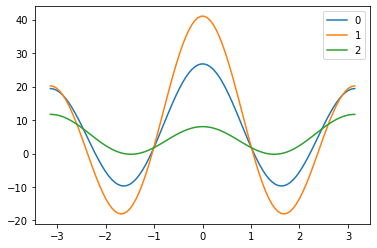

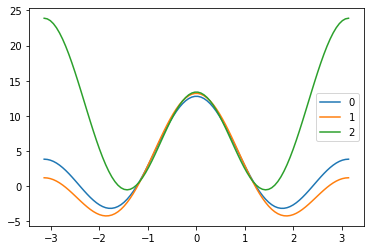

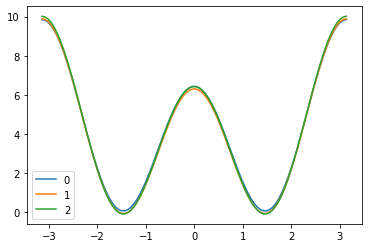

In [16]:
for i in range(len(results)):
    out = karplus_eqs(results.iloc[i][['A_gamma', 'B_gamma', 'C_gamma']], i)
plt.legend()

plt.figure()
for i in range(len(results)):
    out = karplus_eqs(results.iloc[i][['A_beta', 'B_beta', 'C_beta']], i)
plt.legend()

plt.figure()
for i in range(len(results)):
    out = karplus_eqs(results.iloc[i][['A_sugar', 'B_sugar', 'C_sugar']], i)
plt.legend()

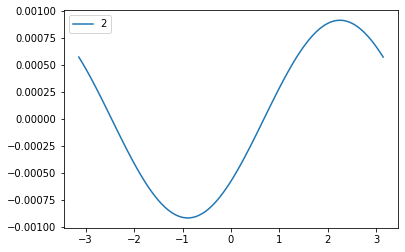

In [17]:
for i in range(len(results)):
    out = ff_correction(results.iloc[i][['sin alpha', 'cos alpha']], i)
plt.legend()

In [18]:
# chi2 in cross validation

print('normalized chi2 on the cross-validation dataset:')

i = 0
chi2_cv['no fff'] = np.sum(results[i][[s for s in list(results[i].columns) if s.startswith('chi2')]].values)/n_obs_cv
print('without force-field fitting: ', chi2_cv['no fff'])

i = 1
chi2_cv['with fff'] = np.sum(results[i][[s for s in list(results[i].columns) if s.startswith('chi2')]].values)/n_obs_cv
print('with force-field fitting: ', chi2_cv['with fff'])


normalized chi2 on the cross-validation dataset:


KeyError: 0

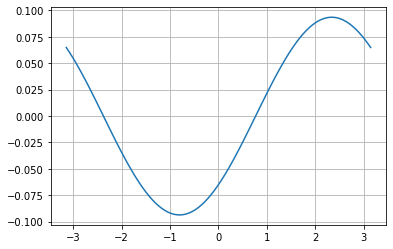

In [30]:
alpha = np.linspace(-np.pi, np.pi, 100)

ff = float(results[1]['sin alpha'])*np.sin(alpha) + float(results[1]['cos alpha'])*np.cos(alpha)

plt.plot(alpha, ff)
plt.grid()


In [65]:
n_obs_test = np.sum([np.sum(list(data_test.mol[s].n_experiments_new.values())) for s in data_test.mol.keys()])

n_obs_test

75

In [25]:
# n. obs. in validation when there is a test set
n_obs_valid = np.sum([np.sum(list(data_valid.mol[s].n_experiments_new.values())) for s in data_valid.mol.keys()])
# n. obs. in validation in the absence of the (external) test set
data1_training, data1_valid, valid_obs, valid_frames = split_dataset(data, frames_fraction=0.2, random_state=1, obs_fraction=0.2)
n_obs_valid_only = np.sum([np.sum(list(data1_valid.mol[s].n_experiments_new.values())) for s in data1_valid.mol.keys()])


print(n_obs_valid, n_obs_valid_only)

chi2_valid = []

for i in range(len(dfs_hyper)):
    if sims.iloc[i]['if_test'] == True:
        chi2_valid.append(dfs_hyper[i]['av_chi2'].iloc[-1] / n_obs_valid)
    else:
        chi2_valid.append(dfs_hyper[i]['av_chi2'].iloc[-1] / n_obs_valid_only)

chi2_valid

Input random_state employed both for observables and frames
429 478


[1.280410729456635, 0.8927058187131457, 0.9277043732576493]

In [31]:
my_strs = ['no fff', 'with fff']

for i, my_s in enumerate(my_strs):

    coeffs = results[i][fm_coeff_names].values[0]

    # input: coeffs, data_test, (path, my_list, i -> w), test_obs, n_test_obs
    chi2 = 0

    for name_mol in data_test.properties.system_names:

        # w = data.mol[name_mol].weights
        w = np.load(my_list[i] + '/weights_new_%s.npy' % name_mol)

        # g = data_test.mol[name_mol].forward_model(coeffs, data_test.mol[name_mol].forward_qs, test_obs[name_mol])
        g = forward_model_fun(coeffs, data_test.mol[name_mol].forward_qs, test_obs[name_mol])
        g['NOEs'] = data_test.mol[name_mol].g['NOEs']  # since no forward model correction
        g['uNOEs'] = data_test.mol[name_mol].g['uNOEs']

        # g = data_test.mol[name_mol].g

        ks = [k for k in data_test.mol[name_mol].gexp.keys() if data_test.mol[name_mol].gexp[k].shape[0] == 0]
        for k in ks: del data_test.mol[name_mol].gexp[k]

        chi2 += compute_chi2(data_test.mol[name_mol].ref, w, g, data_test.mol[name_mol].gexp)[-1]

    chi2_test[my_s] = chi2/n_obs_test

print('normalized chi2 on the test set:')
print('without force-field fitting: ', chi2_test['no fff'])
print('with force-field fitting: ', chi2_test['with fff'])

ValueError: Size of label 'i' for operand 1 (101700) does not match previous terms (10170).

In [27]:
print(chi2_cv, chi2_test)

{'ref': DeviceArray(71.23022841, dtype=float64), 'no fff': 0.15607912252496478, 'with fff': 0.1544798787643205} {'ref': DeviceArray(2.96619064, dtype=float64), 'no fff': DeviceArray(1.69218325, dtype=float64), 'with fff': DeviceArray(1.58684754, dtype=float64)}


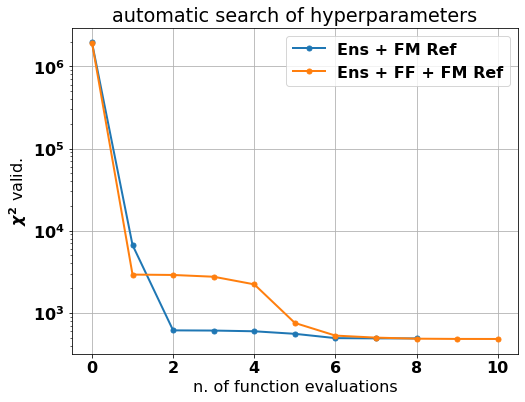

In [28]:
font = {'weight' : 'bold', 'size' : 16}

# plt.rcdefaults()
matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 10

plt.figure(figsize=(8, 6))
plt.plot(dfs_hyper[0]['av_chi2'], '.-', label='Ens + FM Ref')
plt.plot(dfs_hyper[1]['av_chi2'], '.-', label='Ens + FF + FM Ref')

plt.yscale('log')
plt.grid()
plt.xlabel('n. of function evaluations')
plt.ylabel(r'$\chi^2$ valid.')
plt.title('automatic search of hyperparameters')
plt.legend()

# plt.savefig('../../Figures/hyper_search.pdf', format='pdf', bbox_inches='tight')

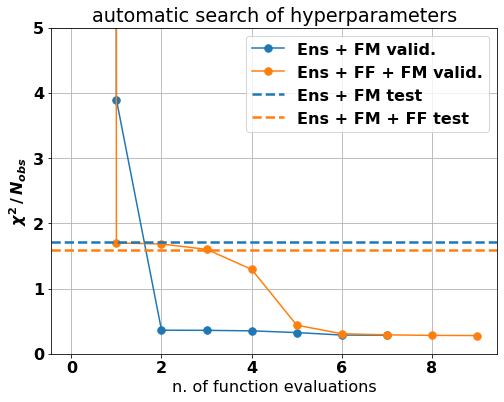

In [45]:
font = {'weight' : 'bold', 'size' : 16}

# plt.rcdefaults()
matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['lines.markersize'] = 15

plt.figure(figsize=(8, 6))
plt.plot(dfs_hyper[0]['av_chi2']/n_obs_valid, '.-', label='Ens + FM valid.', linewidth=1.5)
plt.plot(dfs_hyper[1]['av_chi2']/n_obs_valid, '.-', label='Ens + FF + FM valid.', linewidth=1.5)

xlims = plt.xlim()

plt.plot(xlims, chi2_test['no fff']*np.ones(2), '--', color='tab:blue', label='Ens + FM test')
plt.plot(xlims, chi2_test['with fff']*np.ones(2), '--', color='tab:orange', label='Ens + FM + FF test')

plt.xlim(xlims)
# plt.yscale('log')
plt.ylim([0, 5])
plt.grid()
plt.xlabel('n. of function evaluations')
plt.ylabel(r'$\chi^2 \, / \, N_{obs}$')
plt.title('automatic search of hyperparameters')
plt.legend(loc='upper right')

# plt.savefig('../../Figures/performance.pdf', format='pdf', bbox_inches='tight')

In [30]:
def plot_DataFrame(df, labels=None, xticks_name=None):

        barWidth = 1/(len(df.columns) + 1)

        plt.subplots(figsize=(12, 8)) 

        brs = []
        brs.append(np.arange(len(df.iloc[:, 0])))

        if labels == None: labels = df.columns
        if xticks_name == None: xticks_name = list(df.index)
        
        plt.bar(brs[-1], df.iloc[:, 0], label=labels[0], width=barWidth)  # edgecolor ='grey', color ='tab:blue')

        for i in range(1, len(df.columns)):
                brs.append([x + barWidth for x in brs[-1]])
                plt.bar(brs[-1], df.iloc[:, i], label=labels[i], width=barWidth)  # edgecolor ='grey', color ='tab:blue')

        plt.xticks([r + barWidth*(len(df.columns) - 1)/2 for r in range(len(df.iloc[:, 0]))], xticks_name)
        # plt.xticks([r + barWidth for r in range(len(df.iloc[:, 0]))], list(df.index))
        # plt.xlabel(list(df.index))
        
        # plt.xlabel('Branch', fontweight ='bold', fontsize = 15) 
        # plt.ylabel('Students passed', fontweight ='bold', fontsize = 15) 
        # plt.xticks([r + barWidth for r in range(len(df['Aduri'].iloc[:-1]))], names_charges)

        plt.legend()
        plt.gca().xaxis.grid(True)
        # plt.grid()
        # plt.show()

        return

                        original               E + FM          E + FM + FF
training obs.   71.2302284101466             0.163042              0.16273
test obs.      2.966190636557579  0.07729438769725157  0.07686032098801326


<Figure size 288x288 with 0 Axes>

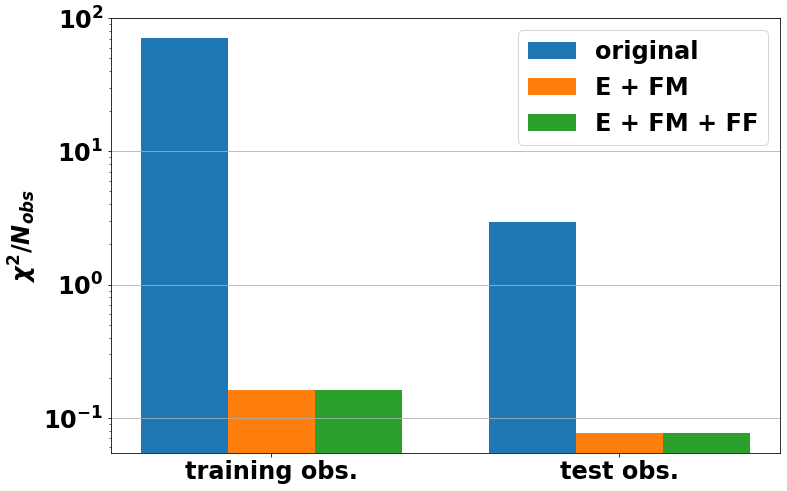

In [42]:
font = {'weight' : 'bold', 'size' : 24}
matplotlib.rc('font', **font)

my_dict = {'training obs.': chi2_cv, 'test obs.': chi2_test}
df = pandas.DataFrame(my_dict).transpose()
df.columns = ['original', 'E + FM', 'E + FM + FF']

print(df)

plt.figure(figsize=(4, 4))
plot_DataFrame(df)
plt.ylabel(r'$\chi^2 / N_{obs}$')
plt.legend()
plt.grid()
# plt.ylim([0, 5])
plt.yscale('log')

# plt.savefig('../../Figures/performance.pdf', format='pdf', bbox_inches='tight')